# Data Preprocessing

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from Bio import SeqIO
from copy import deepcopy

# Added this for mac compatibility
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


In [2]:
# Helper to read FASTA file sequences
def read_fasta(file_path):
    try:
        sequences = []
        for record in SeqIO.parse(file_path, "fasta"):
            sequences.append(str(record.seq))
        return sequences
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return []

# Load positive and negative sequences
positive_pairs = read_fasta('data/positive_pairs.fasta')
negative_pairs = read_fasta('data/negative_pairs.fasta')

print(f"Number of positive sequences: {len(positive_pairs)}")
print(f"Number of negative sequences: {len(negative_pairs)}")

Number of positive sequences: 7000
Number of negative sequences: 6679


In [3]:
# Function to check if a sequence contains only standard amino acids
def is_valid_sequence(sequence):
    valid_vocab = set('ABCDEFGHIKLMNPQRSTUVWYXZ_')
    return all(char in valid_vocab for char in sequence), set(sequence) - valid_vocab

# Filter the sequence dictionary
filtered_positive = []
filtered_negative = []

for seq in positive_pairs:
    is_valid, invalid_chars = is_valid_sequence(seq)
    if is_valid:
        filtered_positive.append(seq)
    else:
        print(f"Sequence {seq} contains unknown amino acids: {', '.join(invalid_chars)} and will be excluded.")

for seq in negative_pairs:
    is_valid, invalid_chars = is_valid_sequence(seq)
    if is_valid:
        filtered_negative.append(seq)
    else:
        print(f"Sequence {seq} contains unknown amino acids: {', '.join(invalid_chars)} and will be excluded.")

print(f"Number of filtered positive sequences: {len(filtered_positive)}")
print(f"Number of filtered negative sequences: {len(filtered_negative)}")

Number of filtered positive sequences: 7000
Number of filtered negative sequences: 6679


### Create Labels

In [4]:
# Create labels
positive_labels = [1] * len(filtered_positive)
negative_labels = [0] * len(filtered_negative)

# Combine sequences and labels
all_sequences = filtered_positive + filtered_negative
all_labels = positive_labels + negative_labels

In [5]:
# Collect all unique amino acid letters
all_letters = set(''.join(all_sequences))
print(f'Unique amino acids: {all_letters}')

# Create a mapping from letters to integers, reserving 0 for padding
letter_to_int = {letter: idx + 1 for idx, letter in enumerate(sorted(all_letters))}
letter_to_int['<PAD>'] = 0  # Padding token

print(f'Letter to integer mapping: {letter_to_int}')

Unique amino acids: {'N', 'R', 'I', 'T', 'D', 'A', 'M', '_', 'L', 'Z', 'K', 'V', 'E', 'X', 'C', 'G', 'F', 'W', 'Q', 'S', 'P', 'H', 'Y', 'U'}
Letter to integer mapping: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 18, 'V': 19, 'W': 20, 'X': 21, 'Y': 22, 'Z': 23, '_': 24, '<PAD>': 0}


### Integer Encode Sequences (1-Hot encoding is TOO LARGE since the vocab size is 25 and sequences are padded to length 3000)

In [6]:
# Encode the sequences and convert to tensors (skip padding for now)
encoded_sequences = []
for seq in all_sequences:
    try:
        encoded_seq = [letter_to_int[aa] for aa in seq]
        encoded_sequences.append(torch.tensor(encoded_seq, dtype=torch.long))
    except KeyError as e:
        print(f"Error encoding sequence: {seq}. Unmapped character {e}.")

all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)

### Pad sequences to length 3000 and remove sequences that are too long

In [7]:
# Set maximum sequence length
max_seq_len = 3000

# Pair sequences with their corresponding labels
filtered_sequences_with_labels = [
    (seq, label) for seq, label in zip(encoded_sequences, all_labels_tensor) if len(seq) <= max_seq_len
]

print(f"Number of sequences after filtering: {len(filtered_sequences_with_labels)}")

# Define a function to pad a batch of sequences and keep labels
def batch_pad_with_labels(batch, max_length, padding_value):
    padded_sequences = []
    labels = []
    for seq, label in batch:
        padding_needed = max_length - len(seq)
        padded_seq = torch.cat([seq, torch.full((padding_needed,), padding_value, dtype=torch.long)])
        padded_sequences.append(padded_seq)
        labels.append(label)
    return torch.stack(padded_sequences), torch.tensor(labels, dtype=torch.long)

# Process sequences and labels in batches
batch_size = 64
padded_batches = []
label_batches = []
for i in range(0, len(filtered_sequences_with_labels), batch_size):
    batch = filtered_sequences_with_labels[i:i + batch_size]
    padded_batch, label_batch = batch_pad_with_labels(batch, max_seq_len, letter_to_int['<PAD>'])
    padded_batches.append(padded_batch)
    label_batches.append(label_batch)

# Combine all padded batches into a single tensor
padded_sequences = torch.cat(padded_batches, dim=0)
labels = torch.cat(label_batches, dim=0)

print(f"Padded sequences shape: {padded_sequences.shape}")
print(f"Labels shape: {labels.shape}")

Number of sequences after filtering: 13378
Padded sequences shape: torch.Size([13378, 3000])
Labels shape: torch.Size([13378])


### Create 70/15/15 Train/Dev/Test Split

In [8]:
# Split into train and temporary test set
X_train, X_temp, y_train, y_temp = train_test_split(
    padded_sequences, 
    labels,
    test_size=0.3,  
    random_state=42,
    stratify=labels  
)

# Split the temp set into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Print shapes and class distributions
print("\nData split summary:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"  Positive: {torch.sum(y_train == 1)} ({torch.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_train == 0)} ({torch.sum(y_train == 0)/len(y_train)*100:.1f}%)")

print(f"\nValidation set: {X_val.shape[0]} samples")
print(f"  Positive: {torch.sum(y_val == 1)} ({torch.sum(y_val == 1)/len(y_val)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_val == 0)} ({torch.sum(y_val == 0)/len(y_val)*100:.1f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  Positive: {torch.sum(y_test == 1)} ({torch.sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_test == 0)} ({torch.sum(y_test == 0)/len(y_test)*100:.1f}%)")


# Create DataLoader with float labels
train_dataset = torch.utils.data.TensorDataset(X_train, y_train.float())
val_dataset = torch.utils.data.TensorDataset(X_val, y_val.float())
test_dataset = torch.utils.data.TensorDataset(X_test, y_test.float())

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Data split summary:
Training set: 9364 samples
  Positive: 4739 (50.6%)
  Negative: 4625 (49.4%)

Validation set: 2007 samples
  Positive: 1016 (50.6%)
  Negative: 991 (49.4%)

Test set: 2007 samples
  Positive: 1015 (50.6%)
  Negative: 992 (49.4%)


# Test Simple Neural Network for Binary Classification

In [9]:
class ProteinSequenceClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=1024):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Flatten the embedded sequence
        input_dim = embedding_dim * max_seq_len
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        return self.model(x).squeeze()

# Initialize model, loss function, and optimizer
vocab_size = len(letter_to_int)
model = ProteinSequenceClassifier(vocab_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Training function with gradient clipping to avoid gradient explosion
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend((outputs > 0.5).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(train_loader), predictions, true_labels

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend((outputs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, zero_division=0),
        'recall': recall_score(true_labels, predictions, zero_division=0),
        'f1': f1_score(true_labels, predictions, zero_division=0)
    }

# Training loop
n_epochs = 50
train_losses = []
val_metrics = []

for epoch in range(n_epochs):
    # Train
    loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(loss)
    
    # Evaluate
    train_metrics = evaluate(model, train_loader)
    val_metrics_epoch = evaluate(model, val_loader)
    val_metrics.append(val_metrics_epoch)
    
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {loss:.4f}")
    print(f"Train Metrics: Accuracy={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}")
    print(f"Val Metrics: Accuracy={val_metrics_epoch['accuracy']:.4f}, F1={val_metrics_epoch['f1']:.4f}")

# Final evaluation on test set
test_metrics = evaluate(model, test_loader)
print("\nFinal Test Set Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")

Training: 100%|██████████| 74/74 [00:01<00:00, 44.66it/s]



Epoch 1/50
Train Loss: 0.4983
Train Metrics: Accuracy=0.9550, F1=0.9555
Val Metrics: Accuracy=0.8052, F1=0.8252


Training: 100%|██████████| 74/74 [00:01<00:00, 62.46it/s]



Epoch 2/50
Train Loss: 0.1541
Train Metrics: Accuracy=0.9852, F1=0.9854
Val Metrics: Accuracy=0.7982, F1=0.8223


Training: 100%|██████████| 74/74 [00:01<00:00, 58.56it/s]



Epoch 3/50
Train Loss: 0.0613
Train Metrics: Accuracy=0.9949, F1=0.9949
Val Metrics: Accuracy=0.7987, F1=0.8167


Training: 100%|██████████| 74/74 [00:01<00:00, 62.73it/s]



Epoch 4/50
Train Loss: 0.0288
Train Metrics: Accuracy=0.9977, F1=0.9977
Val Metrics: Accuracy=0.7987, F1=0.8183


Training: 100%|██████████| 74/74 [00:01<00:00, 63.10it/s]



Epoch 5/50
Train Loss: 0.0156
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7947, F1=0.8073


Training: 100%|██████████| 74/74 [00:01<00:00, 62.77it/s]



Epoch 6/50
Train Loss: 0.0097
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7972, F1=0.8147


Training: 100%|██████████| 74/74 [00:01<00:00, 62.96it/s]



Epoch 7/50
Train Loss: 0.0040
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7962, F1=0.8138


Training: 100%|██████████| 74/74 [00:01<00:00, 62.99it/s]



Epoch 8/50
Train Loss: 0.0034
Train Metrics: Accuracy=0.9996, F1=0.9996
Val Metrics: Accuracy=0.7942, F1=0.8132


Training: 100%|██████████| 74/74 [00:01<00:00, 62.98it/s]



Epoch 9/50
Train Loss: 0.0029
Train Metrics: Accuracy=0.9995, F1=0.9995
Val Metrics: Accuracy=0.7922, F1=0.8114


Training: 100%|██████████| 74/74 [00:01<00:00, 62.22it/s]



Epoch 10/50
Train Loss: 0.0062
Train Metrics: Accuracy=0.9986, F1=0.9986
Val Metrics: Accuracy=0.7853, F1=0.8072


Training: 100%|██████████| 74/74 [00:01<00:00, 62.82it/s]



Epoch 11/50
Train Loss: 0.0211
Train Metrics: Accuracy=0.9921, F1=0.9922
Val Metrics: Accuracy=0.7758, F1=0.7951


Training: 100%|██████████| 74/74 [00:01<00:00, 62.91it/s]



Epoch 12/50
Train Loss: 0.0695
Train Metrics: Accuracy=0.9862, F1=0.9864
Val Metrics: Accuracy=0.7803, F1=0.7963


Training: 100%|██████████| 74/74 [00:01<00:00, 62.86it/s]



Epoch 13/50
Train Loss: 0.0590
Train Metrics: Accuracy=0.9968, F1=0.9968
Val Metrics: Accuracy=0.7897, F1=0.8070


Training: 100%|██████████| 74/74 [00:01<00:00, 62.88it/s]



Epoch 14/50
Train Loss: 0.0239
Train Metrics: Accuracy=0.9970, F1=0.9971
Val Metrics: Accuracy=0.7942, F1=0.8137


Training: 100%|██████████| 74/74 [00:01<00:00, 62.32it/s]



Epoch 15/50
Train Loss: 0.0147
Train Metrics: Accuracy=0.9988, F1=0.9988
Val Metrics: Accuracy=0.7907, F1=0.8061


Training: 100%|██████████| 74/74 [00:01<00:00, 61.94it/s]



Epoch 16/50
Train Loss: 0.0107
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7952, F1=0.8133


Training: 100%|██████████| 74/74 [00:01<00:00, 62.70it/s]



Epoch 17/50
Train Loss: 0.0046
Train Metrics: Accuracy=0.9995, F1=0.9995
Val Metrics: Accuracy=0.7828, F1=0.7928


Training: 100%|██████████| 74/74 [00:01<00:00, 62.71it/s]



Epoch 18/50
Train Loss: 0.0033
Train Metrics: Accuracy=0.9995, F1=0.9995
Val Metrics: Accuracy=0.7862, F1=0.7981


Training: 100%|██████████| 74/74 [00:01<00:00, 62.42it/s]



Epoch 19/50
Train Loss: 0.0037
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7892, F1=0.8064


Training: 100%|██████████| 74/74 [00:01<00:00, 62.47it/s]



Epoch 20/50
Train Loss: 0.0036
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7872, F1=0.8015


Training: 100%|██████████| 74/74 [00:01<00:00, 62.47it/s]



Epoch 21/50
Train Loss: 0.0033
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7897, F1=0.8009


Training: 100%|██████████| 74/74 [00:01<00:00, 61.70it/s]



Epoch 22/50
Train Loss: 0.0055
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7867, F1=0.7994


Training: 100%|██████████| 74/74 [00:01<00:00, 61.69it/s]



Epoch 23/50
Train Loss: 0.0079
Train Metrics: Accuracy=0.9978, F1=0.9978
Val Metrics: Accuracy=0.7942, F1=0.8084


Training: 100%|██████████| 74/74 [00:01<00:00, 62.36it/s]



Epoch 24/50
Train Loss: 0.0078
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7862, F1=0.7994


Training: 100%|██████████| 74/74 [00:01<00:00, 62.23it/s]



Epoch 25/50
Train Loss: 0.0195
Train Metrics: Accuracy=0.9977, F1=0.9977
Val Metrics: Accuracy=0.7773, F1=0.7860


Training: 100%|██████████| 74/74 [00:01<00:00, 62.01it/s]



Epoch 26/50
Train Loss: 0.0158
Train Metrics: Accuracy=0.9973, F1=0.9974
Val Metrics: Accuracy=0.7927, F1=0.8131


Training: 100%|██████████| 74/74 [00:01<00:00, 62.30it/s]



Epoch 27/50
Train Loss: 0.0151
Train Metrics: Accuracy=0.9984, F1=0.9984
Val Metrics: Accuracy=0.7957, F1=0.8075


Training: 100%|██████████| 74/74 [00:01<00:00, 62.46it/s]



Epoch 28/50
Train Loss: 0.0218
Train Metrics: Accuracy=0.9983, F1=0.9983
Val Metrics: Accuracy=0.8022, F1=0.8190


Training: 100%|██████████| 74/74 [00:01<00:00, 62.24it/s]



Epoch 29/50
Train Loss: 0.0152
Train Metrics: Accuracy=0.9988, F1=0.9988
Val Metrics: Accuracy=0.7937, F1=0.8096


Training: 100%|██████████| 74/74 [00:01<00:00, 61.98it/s]



Epoch 30/50
Train Loss: 0.0083
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7937, F1=0.8090


Training: 100%|██████████| 74/74 [00:01<00:00, 62.10it/s]



Epoch 31/50
Train Loss: 0.0055
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7932, F1=0.8092


Training: 100%|██████████| 74/74 [00:01<00:00, 62.33it/s]



Epoch 32/50
Train Loss: 0.0048
Train Metrics: Accuracy=0.9996, F1=0.9996
Val Metrics: Accuracy=0.7912, F1=0.8074


Training: 100%|██████████| 74/74 [00:01<00:00, 62.09it/s]



Epoch 33/50
Train Loss: 0.0086
Train Metrics: Accuracy=0.9985, F1=0.9985
Val Metrics: Accuracy=0.7932, F1=0.8085


Training: 100%|██████████| 74/74 [00:01<00:00, 62.28it/s]



Epoch 34/50
Train Loss: 0.0076
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7922, F1=0.8027


Training: 100%|██████████| 74/74 [00:01<00:00, 62.40it/s]



Epoch 35/50
Train Loss: 0.0037
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7902, F1=0.8054


Training: 100%|██████████| 74/74 [00:01<00:00, 62.47it/s]



Epoch 36/50
Train Loss: 0.0045
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7857, F1=0.7923


Training: 100%|██████████| 74/74 [00:01<00:00, 62.49it/s]



Epoch 37/50
Train Loss: 0.0092
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7838, F1=0.7968


Training: 100%|██████████| 74/74 [00:01<00:00, 62.37it/s]



Epoch 38/50
Train Loss: 0.0147
Train Metrics: Accuracy=0.9971, F1=0.9972
Val Metrics: Accuracy=0.7907, F1=0.8096


Training: 100%|██████████| 74/74 [00:01<00:00, 62.38it/s]



Epoch 39/50
Train Loss: 0.0181
Train Metrics: Accuracy=0.9984, F1=0.9984
Val Metrics: Accuracy=0.7848, F1=0.7968


Training: 100%|██████████| 74/74 [00:01<00:00, 61.76it/s]



Epoch 40/50
Train Loss: 0.0166
Train Metrics: Accuracy=0.9981, F1=0.9981
Val Metrics: Accuracy=0.7882, F1=0.8013


Training: 100%|██████████| 74/74 [00:01<00:00, 62.20it/s]



Epoch 41/50
Train Loss: 0.0252
Train Metrics: Accuracy=0.9987, F1=0.9987
Val Metrics: Accuracy=0.7897, F1=0.8096


Training: 100%|██████████| 74/74 [00:01<00:00, 62.30it/s]



Epoch 42/50
Train Loss: 0.0196
Train Metrics: Accuracy=0.9987, F1=0.9987
Val Metrics: Accuracy=0.7937, F1=0.8064


Training: 100%|██████████| 74/74 [00:01<00:00, 62.41it/s]



Epoch 43/50
Train Loss: 0.0160
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7967, F1=0.8070


Training: 100%|██████████| 74/74 [00:01<00:00, 62.47it/s]



Epoch 44/50
Train Loss: 0.0136
Train Metrics: Accuracy=0.9989, F1=0.9989
Val Metrics: Accuracy=0.7967, F1=0.8115


Training: 100%|██████████| 74/74 [00:01<00:00, 62.38it/s]



Epoch 45/50
Train Loss: 0.0144
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7892, F1=0.8000


Training: 100%|██████████| 74/74 [00:01<00:00, 62.43it/s]



Epoch 46/50
Train Loss: 0.0152
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7877, F1=0.8076


Training: 100%|██████████| 74/74 [00:01<00:00, 62.76it/s]



Epoch 47/50
Train Loss: 0.0123
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7877, F1=0.8028


Training: 100%|██████████| 74/74 [00:01<00:00, 62.23it/s]



Epoch 48/50
Train Loss: 0.0128
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7862, F1=0.8020


Training: 100%|██████████| 74/74 [00:01<00:00, 62.20it/s]



Epoch 49/50
Train Loss: 0.0157
Train Metrics: Accuracy=0.9989, F1=0.9989
Val Metrics: Accuracy=0.7887, F1=0.8028


Training: 100%|██████████| 74/74 [00:01<00:00, 62.17it/s]



Epoch 50/50
Train Loss: 0.0092
Train Metrics: Accuracy=0.9990, F1=0.9991
Val Metrics: Accuracy=0.7897, F1=0.8075

Final Test Set Metrics:
Accuracy: 0.7838
Precision: 0.7451
Recall: 0.8700
F1 Score: 0.8027


### Plot Training Curve

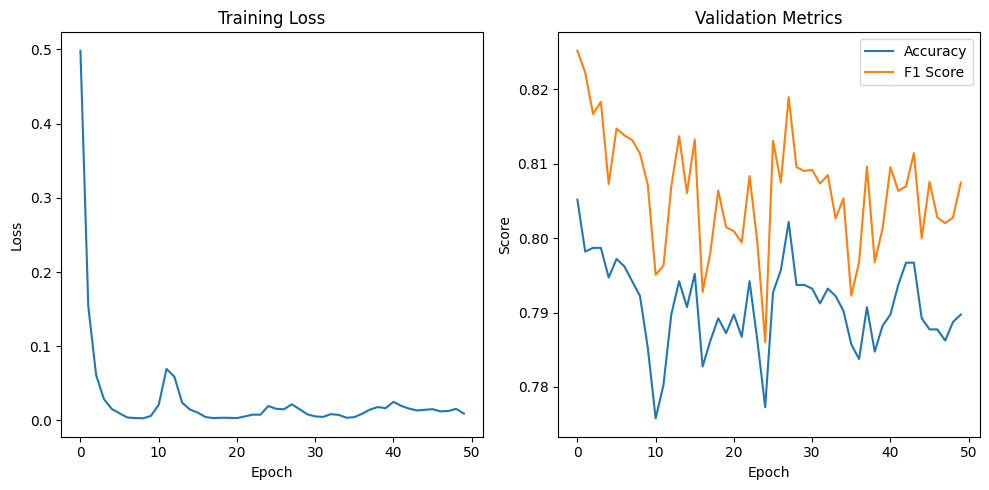

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([m['accuracy'] for m in val_metrics], label='Accuracy')
plt.plot([m['f1'] for m in val_metrics], label='F1 Score')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

# Comprehensive Training Suite to compare Neural Network Models with different hyperparameters


Training Logistic Regression...


Training: 100%|██████████| 37/37 [00:00<00:00, 105.29it/s]



Epoch 5/30
Train Loss: 0.0625
Train Metrics: Accuracy=0.9985, F1=0.9985
Val Metrics: Accuracy=0.7693, F1=0.7769


Training: 100%|██████████| 37/37 [00:00<00:00, 107.93it/s]



Epoch 10/30
Train Loss: 0.0333
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7638, F1=0.7653


Training: 100%|██████████| 37/37 [00:00<00:00, 106.32it/s]



Epoch 15/30
Train Loss: 0.0328
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7603, F1=0.7587


Training: 100%|██████████| 37/37 [00:00<00:00, 106.43it/s]



Epoch 20/30
Train Loss: 0.0373
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7673, F1=0.7687


Training: 100%|██████████| 37/37 [00:00<00:00, 105.83it/s]



Epoch 25/30
Train Loss: 0.0379
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7474, F1=0.7355


Training: 100%|██████████| 37/37 [00:00<00:00, 106.09it/s]



Epoch 30/30
Train Loss: 0.0399
Train Metrics: Accuracy=0.9993, F1=0.9993
Val Metrics: Accuracy=0.7509, F1=0.7407

Logistic Regression Final Test Metrics:
Accuracy: 0.7693
Precision: 0.7589
Recall: 0.7970
F1 Score: 0.7775

Training Small Model...


Training: 100%|██████████| 37/37 [00:00<00:00, 88.12it/s]



Epoch 5/30
Train Loss: 0.0184
Train Metrics: Accuracy=0.9983, F1=0.9983
Val Metrics: Accuracy=0.7982, F1=0.8089


Training: 100%|██████████| 37/37 [00:00<00:00, 88.94it/s]



Epoch 10/30
Train Loss: 0.0034
Train Metrics: Accuracy=0.9995, F1=0.9995
Val Metrics: Accuracy=0.7992, F1=0.8091


Training: 100%|██████████| 37/37 [00:00<00:00, 88.98it/s]



Epoch 15/30
Train Loss: 0.0022
Train Metrics: Accuracy=0.9995, F1=0.9995
Val Metrics: Accuracy=0.7997, F1=0.8098


Training: 100%|██████████| 37/37 [00:00<00:00, 88.93it/s]



Epoch 20/30
Train Loss: 0.0016
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.8007, F1=0.8113


Training: 100%|██████████| 37/37 [00:00<00:00, 87.90it/s]



Epoch 25/30
Train Loss: 0.0012
Train Metrics: Accuracy=0.9996, F1=0.9996
Val Metrics: Accuracy=0.7967, F1=0.8085


Training: 100%|██████████| 37/37 [00:00<00:00, 88.67it/s]



Epoch 30/30
Train Loss: 0.0014
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7957, F1=0.8075

Small Model Final Test Metrics:
Accuracy: 0.7862
Precision: 0.7470
Recall: 0.8729
F1 Score: 0.8051

Training Medium Model...


Training: 100%|██████████| 74/74 [00:00<00:00, 93.81it/s]



Epoch 5/30
Train Loss: 0.0628
Train Metrics: Accuracy=0.9981, F1=0.9981
Val Metrics: Accuracy=0.8052, F1=0.8191


Training: 100%|██████████| 74/74 [00:00<00:00, 93.22it/s]



Epoch 10/30
Train Loss: 0.0195
Train Metrics: Accuracy=0.9991, F1=0.9992
Val Metrics: Accuracy=0.7877, F1=0.8046


Training: 100%|██████████| 74/74 [00:00<00:00, 92.91it/s]



Epoch 15/30
Train Loss: 0.0088
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7788, F1=0.7865


Training: 100%|██████████| 74/74 [00:00<00:00, 93.47it/s]



Epoch 20/30
Train Loss: 0.0048
Train Metrics: Accuracy=0.9995, F1=0.9995
Val Metrics: Accuracy=0.7857, F1=0.8002


Training: 100%|██████████| 74/74 [00:00<00:00, 93.46it/s]



Epoch 25/30
Train Loss: 0.0553
Train Metrics: Accuracy=0.9971, F1=0.9971
Val Metrics: Accuracy=0.7843, F1=0.7919


Training: 100%|██████████| 74/74 [00:00<00:00, 93.77it/s]



Epoch 30/30
Train Loss: 0.0059
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7892, F1=0.7979

Medium Model Final Test Metrics:
Accuracy: 0.7972
Precision: 0.7538
Recall: 0.8897
F1 Score: 0.8161

Training Large Model...


Training: 100%|██████████| 147/147 [00:03<00:00, 44.34it/s]



Epoch 5/30
Train Loss: 0.0943
Train Metrics: Accuracy=0.9979, F1=0.9979
Val Metrics: Accuracy=0.7967, F1=0.8139


Training: 100%|██████████| 147/147 [00:03<00:00, 44.35it/s]



Epoch 10/30
Train Loss: 0.0520
Train Metrics: Accuracy=0.9973, F1=0.9974
Val Metrics: Accuracy=0.7997, F1=0.8163


Training: 100%|██████████| 147/147 [00:03<00:00, 44.38it/s]



Epoch 15/30
Train Loss: 0.0302
Train Metrics: Accuracy=0.9994, F1=0.9994
Val Metrics: Accuracy=0.7773, F1=0.7902


Training: 100%|██████████| 147/147 [00:03<00:00, 44.33it/s]



Epoch 20/30
Train Loss: 0.0234
Train Metrics: Accuracy=0.9984, F1=0.9984
Val Metrics: Accuracy=0.7823, F1=0.8045


Training: 100%|██████████| 147/147 [00:03<00:00, 44.27it/s]



Epoch 25/30
Train Loss: 0.0227
Train Metrics: Accuracy=0.9984, F1=0.9984
Val Metrics: Accuracy=0.7887, F1=0.8073


Training: 100%|██████████| 147/147 [00:03<00:00, 44.21it/s]



Epoch 30/30
Train Loss: 0.0165
Train Metrics: Accuracy=0.9986, F1=0.9986
Val Metrics: Accuracy=0.7902, F1=0.8066

Large Model Final Test Metrics:
Accuracy: 0.7987
Precision: 0.7514
Recall: 0.8995
F1 Score: 0.8188

Training Deep Model...


Training: 100%|██████████| 98/98 [00:00<00:00, 103.36it/s]



Epoch 5/30
Train Loss: 0.0817
Train Metrics: Accuracy=0.9962, F1=0.9962
Val Metrics: Accuracy=0.7942, F1=0.8124


Training: 100%|██████████| 98/98 [00:00<00:00, 103.20it/s]



Epoch 10/30
Train Loss: 0.0416
Train Metrics: Accuracy=0.9969, F1=0.9969
Val Metrics: Accuracy=0.7808, F1=0.7887


Training: 100%|██████████| 98/98 [00:00<00:00, 103.39it/s]



Epoch 15/30
Train Loss: 0.0258
Train Metrics: Accuracy=0.9989, F1=0.9989
Val Metrics: Accuracy=0.7877, F1=0.8024


Training: 100%|██████████| 98/98 [00:00<00:00, 103.30it/s]



Epoch 20/30
Train Loss: 0.0160
Train Metrics: Accuracy=0.9980, F1=0.9980
Val Metrics: Accuracy=0.8022, F1=0.8213


Training: 100%|██████████| 98/98 [00:00<00:00, 102.09it/s]



Epoch 25/30
Train Loss: 0.0219
Train Metrics: Accuracy=0.9983, F1=0.9983
Val Metrics: Accuracy=0.8092, F1=0.8276


Training: 100%|██████████| 98/98 [00:00<00:00, 103.38it/s]



Epoch 30/30
Train Loss: 0.0136
Train Metrics: Accuracy=0.9983, F1=0.9983
Val Metrics: Accuracy=0.8037, F1=0.8247

Deep Model Final Test Metrics:
Accuracy: 0.8047
Precision: 0.7459
Recall: 0.9310
F1 Score: 0.8282


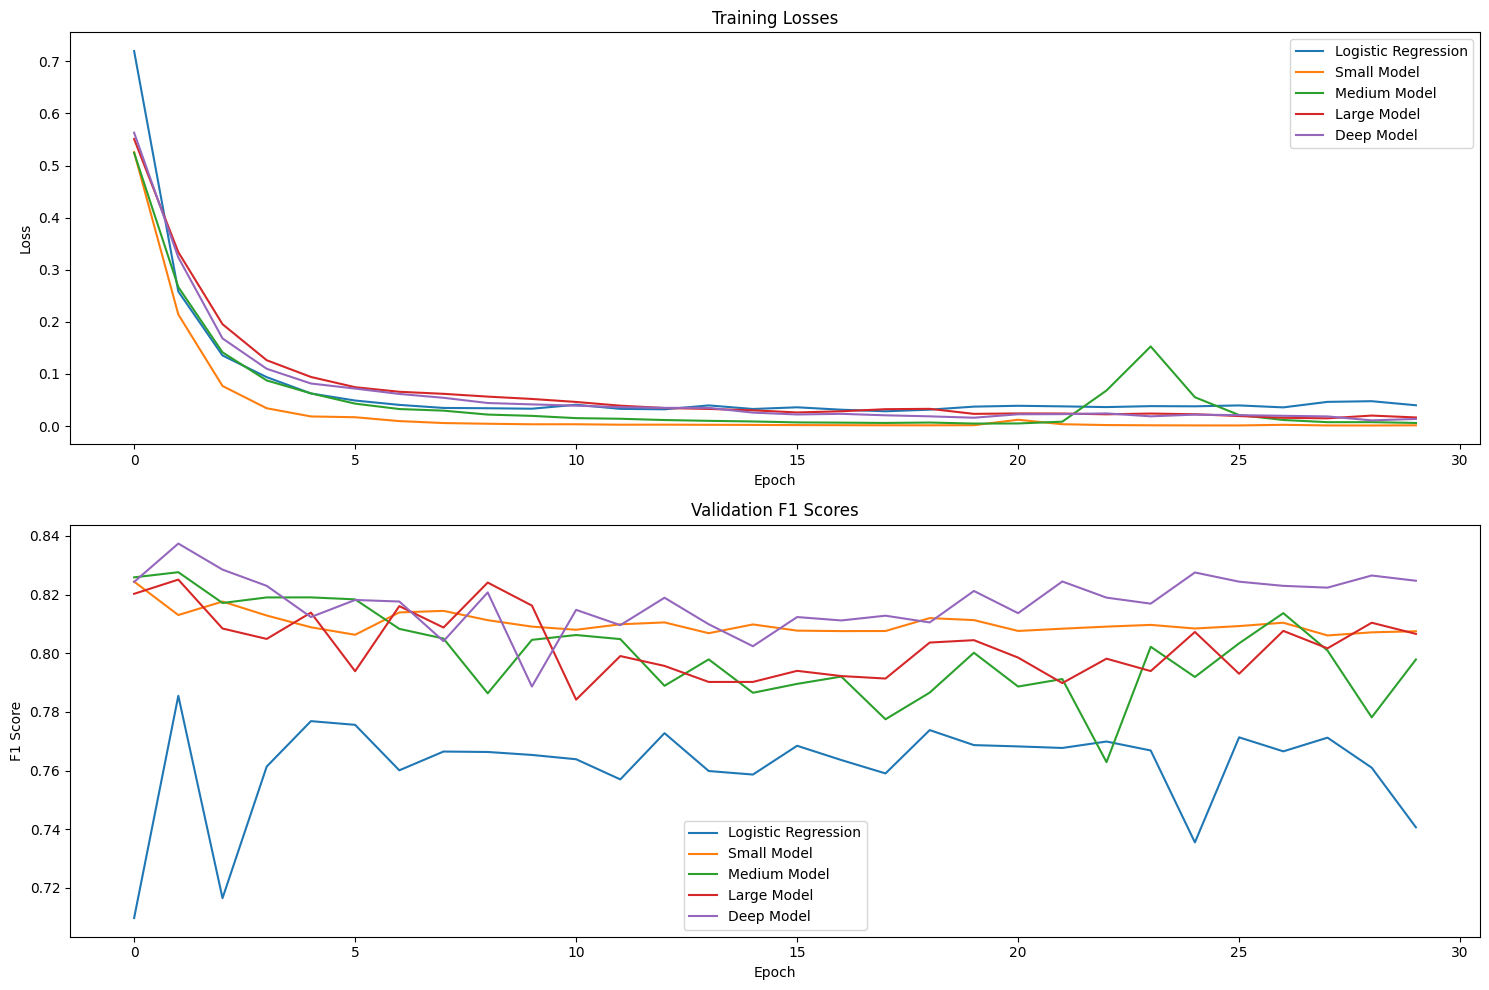


Model Comparison:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1 Score  
--------------------------------------------------------------------------------
Logistic Regression  0.7693     0.7589     0.7970     0.7775
Small Model          0.7862     0.7470     0.8729     0.8051
Medium Model         0.7972     0.7538     0.8897     0.8161
Large Model          0.7987     0.7514     0.8995     0.8188
Deep Model           0.8047     0.7459     0.9310     0.8282


In [11]:
# Model configurations
model_configs = [
    {
        "name": "Logistic Regression",
        "embedding_dim": 32,
        "hidden_dims": [], 
        "dropout_rates": [], 
        "learning_rate": 0.001,
        "batch_size": 256
    },
    {
        "name": "Small Model",
        "embedding_dim": 32,
        "hidden_dims": [256, 64],
        "dropout_rates": [0.1, 0.1],
        "learning_rate": 0.001,
        "batch_size": 256
    },
    {
        "name": "Medium Model",
        "embedding_dim": 64,
        "hidden_dims": [512, 128, 32],
        "dropout_rates": [0.2, 0.2, 0.1],
        "learning_rate": 0.0003,
        "batch_size": 128
    },
    {
        "name": "Large Model",
        "embedding_dim": 128,
        "hidden_dims": [1024, 512, 128, 32],
        "dropout_rates": [0.3, 0.3, 0.2, 0.1],
        "learning_rate": 0.0001,
        "batch_size": 64
    },
    {
        "name": "Deep Model",
        "embedding_dim": 64,
        "hidden_dims": [512, 256, 128, 64, 32],
        "dropout_rates": [0.2, 0.2, 0.2, 0.1, 0.1],
        "learning_rate": 0.0002,
        "batch_size": 96
    }
]

class ProteinSequenceClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dims, dropout_rates):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Flatten the embedded sequence
        input_dim = embedding_dim * max_seq_len
        
        # Build layers dynamically
        layers = []
        current_dim = input_dim
        
        if len(hidden_dims) == 0:  # Logistic regression case
            layers.extend([
                nn.Linear(current_dim, 1),
                nn.Sigmoid()
            ])
        else:  # Neural network case
            for i, hidden_dim in enumerate(hidden_dims):
                layers.extend([
                    nn.Linear(current_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(dropout_rates[i])
                ])
                current_dim = hidden_dim
                
            # Output layer
            layers.extend([
                nn.Linear(current_dim, 1),
                nn.Sigmoid()
            ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        return self.model(x).squeeze()

def train_and_evaluate_model(config, n_epochs=30):
    print(f"\nTraining {config['name']}...")
    
    # Initialize model
    model = ProteinSequenceClassifier(
        vocab_size=len(letter_to_int),
        embedding_dim=config['embedding_dim'],
        hidden_dims=config['hidden_dims'],
        dropout_rates=config['dropout_rates']
    ).to(device)
    
    # Setup training
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    train_losses = []
    val_metrics = []
    best_val_f1 = 0
    best_model = None
    
    for epoch in range(n_epochs):
        # Train
        loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(loss)
        
        # Evaluate
        train_metrics = evaluate(model, train_loader)
        val_metrics_epoch = evaluate(model, val_loader)
        val_metrics.append(val_metrics_epoch)
        
        # Save best model
        if val_metrics_epoch['f1'] > best_val_f1:
            best_val_f1 = val_metrics_epoch['f1']
            best_model = deepcopy(model.state_dict())
        
        if (epoch + 1) % 5 == 0:  # Print every 5 epochs
            print(f"\nEpoch {epoch+1}/{n_epochs}")
            print(f"Train Loss: {loss:.4f}")
            print(f"Train Metrics: Accuracy={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}")
            print(f"Val Metrics: Accuracy={val_metrics_epoch['accuracy']:.4f}, F1={val_metrics_epoch['f1']:.4f}")
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_model)
    test_metrics = evaluate(model, test_loader)
    
    return {
        'name': config['name'],
        'train_losses': train_losses,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model': model
    }

# Train all models
results = []
for config in model_configs:
    result = train_and_evaluate_model(config)
    results.append(result)
    
    print(f"\n{result['name']} Final Test Metrics:")
    print(f"Accuracy: {result['test_metrics']['accuracy']:.4f}")
    print(f"Precision: {result['test_metrics']['precision']:.4f}")
    print(f"Recall: {result['test_metrics']['recall']:.4f}")
    print(f"F1 Score: {result['test_metrics']['f1']:.4f}")

# Plot results
plt.figure(figsize=(15, 10))

# Plot training losses
plt.subplot(2, 1, 1)
for result in results:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation F1 scores
plt.subplot(2, 1, 2)
for result in results:
    f1_scores = [m['f1'] for m in result['val_metrics']]
    plt.plot(f1_scores, label=result['name'])
plt.title('Validation F1 Scores')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# Print comparison table
print("\nModel Comparison:")
print("-" * 80)
print(f"{'Model':20} {'Accuracy':10} {'Precision':10} {'Recall':10} {'F1 Score':10}")
print("-" * 80)
for result in results:
    metrics = result['test_metrics']
    print(f"{result['name']:20} "
          f"{metrics['accuracy']:.4f}     "
          f"{metrics['precision']:.4f}     "
          f"{metrics['recall']:.4f}     "
          f"{metrics['f1']:.4f}")


Training Simple LSTM...


Training: 100%|██████████| 74/74 [00:01<00:00, 72.33it/s]



Epoch 5/30
Train Loss: 0.6935
Train Metrics: Accuracy=0.5060, F1=0.6719
Val Metrics: Accuracy=0.5062, F1=0.6722


Training: 100%|██████████| 74/74 [00:01<00:00, 72.61it/s]



Epoch 10/30
Train Loss: 0.6927
Train Metrics: Accuracy=0.5061, F1=0.6721
Val Metrics: Accuracy=0.5062, F1=0.6722


Training: 100%|██████████| 74/74 [00:01<00:00, 72.68it/s]



Epoch 15/30
Train Loss: 0.6928
Train Metrics: Accuracy=0.5061, F1=0.6721
Val Metrics: Accuracy=0.5062, F1=0.6722


Training: 100%|██████████| 74/74 [00:01<00:00, 72.43it/s]



Epoch 20/30
Train Loss: 0.6930
Train Metrics: Accuracy=0.4942, F1=0.0017
Val Metrics: Accuracy=0.4938, F1=0.0000


Training: 100%|██████████| 74/74 [00:01<00:00, 72.25it/s]



Epoch 25/30
Train Loss: 0.6929
Train Metrics: Accuracy=0.5062, F1=0.6721
Val Metrics: Accuracy=0.5062, F1=0.6722


Training: 100%|██████████| 74/74 [00:01<00:00, 72.14it/s]



Epoch 30/30
Train Loss: 0.6931
Train Metrics: Accuracy=0.5061, F1=0.6721
Val Metrics: Accuracy=0.5062, F1=0.6722

Simple LSTM Final Test Metrics:
Accuracy: 0.5057
Precision: 0.5057
Recall: 1.0000
F1 Score: 0.6717

Training Bidirectional LSTM...


Training: 100%|██████████| 147/147 [00:04<00:00, 32.03it/s]



Epoch 5/30
Train Loss: 0.5900
Train Metrics: Accuracy=0.7149, F1=0.7518
Val Metrics: Accuracy=0.6677, F1=0.7104


Training: 100%|██████████| 147/147 [00:04<00:00, 32.11it/s]



Epoch 10/30
Train Loss: 0.5088
Train Metrics: Accuracy=0.7845, F1=0.7902
Val Metrics: Accuracy=0.7200, F1=0.7250


Training: 100%|██████████| 147/147 [00:04<00:00, 32.04it/s]



Epoch 15/30
Train Loss: 0.4232
Train Metrics: Accuracy=0.8504, F1=0.8532
Val Metrics: Accuracy=0.7569, F1=0.7613


Training: 100%|██████████| 147/147 [00:04<00:00, 32.03it/s]



Epoch 20/30
Train Loss: 0.3394
Train Metrics: Accuracy=0.8815, F1=0.8877
Val Metrics: Accuracy=0.7738, F1=0.7840


Training: 100%|██████████| 147/147 [00:04<00:00, 32.15it/s]



Epoch 25/30
Train Loss: 0.2766
Train Metrics: Accuracy=0.9194, F1=0.9221
Val Metrics: Accuracy=0.8032, F1=0.8082


Training: 100%|██████████| 147/147 [00:04<00:00, 32.05it/s]



Epoch 30/30
Train Loss: 0.2253
Train Metrics: Accuracy=0.9396, F1=0.9407
Val Metrics: Accuracy=0.7967, F1=0.7974

Bidirectional LSTM Final Test Metrics:
Accuracy: 0.8216
Precision: 0.8096
Recall: 0.8463
F1 Score: 0.8276

Training Deep LSTM...


Training: 100%|██████████| 293/293 [01:19<00:00,  3.70it/s]



Epoch 5/30
Train Loss: 0.6163
Train Metrics: Accuracy=0.7024, F1=0.7321
Val Metrics: Accuracy=0.6697, F1=0.7034


Training: 100%|██████████| 293/293 [01:19<00:00,  3.69it/s]



Epoch 10/30
Train Loss: 0.5388
Train Metrics: Accuracy=0.7601, F1=0.7777
Val Metrics: Accuracy=0.7135, F1=0.7364


Training: 100%|██████████| 293/293 [01:19<00:00,  3.68it/s]



Epoch 15/30
Train Loss: 0.4590
Train Metrics: Accuracy=0.8159, F1=0.8338
Val Metrics: Accuracy=0.7618, F1=0.7849


Training: 100%|██████████| 293/293 [01:20<00:00,  3.66it/s]



Epoch 20/30
Train Loss: 0.3758
Train Metrics: Accuracy=0.8752, F1=0.8797
Val Metrics: Accuracy=0.7857, F1=0.7919


Training: 100%|██████████| 293/293 [01:20<00:00,  3.65it/s]



Epoch 25/30
Train Loss: 0.2945
Train Metrics: Accuracy=0.9123, F1=0.9153
Val Metrics: Accuracy=0.8032, F1=0.8082


Training: 100%|██████████| 293/293 [01:19<00:00,  3.69it/s]



Epoch 30/30
Train Loss: 0.2273
Train Metrics: Accuracy=0.9366, F1=0.9382
Val Metrics: Accuracy=0.8151, F1=0.8173

Deep LSTM Final Test Metrics:
Accuracy: 0.7887
Precision: 0.7739
Recall: 0.8227
F1 Score: 0.7975

Training Large LSTM...


Training: 100%|██████████| 196/196 [00:57<00:00,  3.44it/s]



Epoch 5/30
Train Loss: 0.5169
Train Metrics: Accuracy=0.7832, F1=0.7942
Val Metrics: Accuracy=0.7304, F1=0.7442


Training: 100%|██████████| 196/196 [00:56<00:00,  3.45it/s]



Epoch 10/30
Train Loss: 0.2973
Train Metrics: Accuracy=0.9203, F1=0.9227
Val Metrics: Accuracy=0.7997, F1=0.8022


Training: 100%|██████████| 196/196 [00:57<00:00,  3.43it/s]



Epoch 15/30
Train Loss: 0.1639
Train Metrics: Accuracy=0.9535, F1=0.9536
Val Metrics: Accuracy=0.8062, F1=0.7994


Training: 100%|██████████| 196/196 [00:57<00:00,  3.42it/s]



Epoch 20/30
Train Loss: 0.1084
Train Metrics: Accuracy=0.9634, F1=0.9629
Val Metrics: Accuracy=0.8062, F1=0.7990


Training: 100%|██████████| 196/196 [00:57<00:00,  3.41it/s]



Epoch 25/30
Train Loss: 0.0915
Train Metrics: Accuracy=0.9659, F1=0.9657
Val Metrics: Accuracy=0.8336, F1=0.8317


Training: 100%|██████████| 196/196 [00:56<00:00,  3.46it/s]



Epoch 30/30
Train Loss: 0.0966
Train Metrics: Accuracy=0.9640, F1=0.9636
Val Metrics: Accuracy=0.8057, F1=0.7965

Large LSTM Final Test Metrics:
Accuracy: 0.8346
Precision: 0.8274
Recall: 0.8502
F1 Score: 0.8387


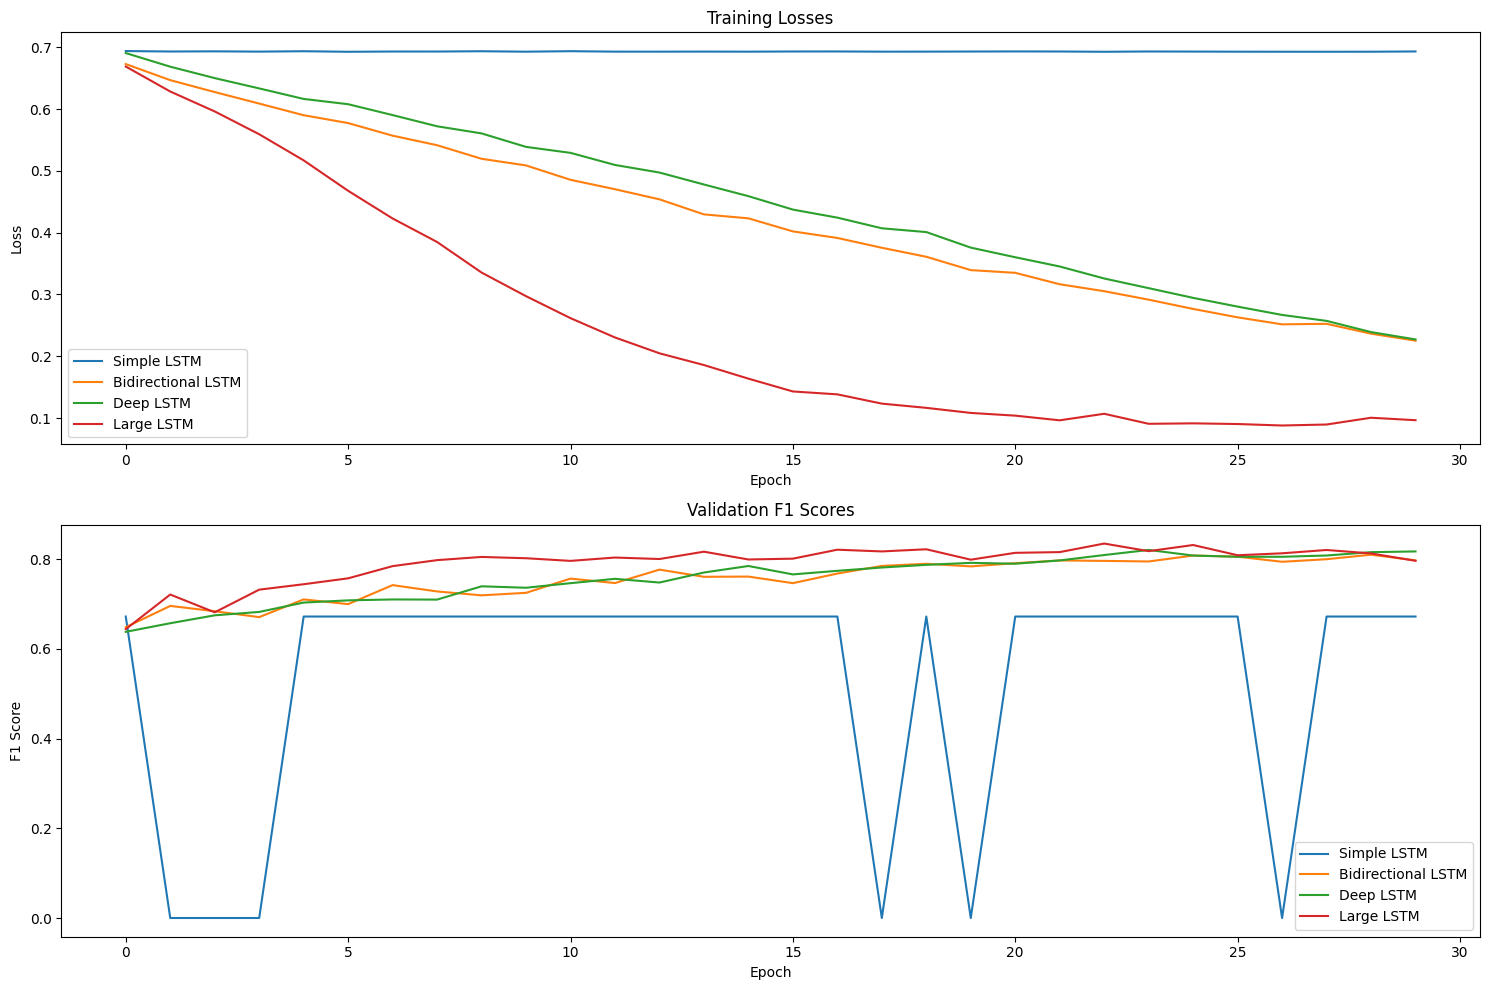


Model Comparison:
----------------------------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1 Score   Parameters   Batch Size
----------------------------------------------------------------------------------------------------
Simple LSTM          0.5057     0.5057     1.0000     0.6717          32353        128
Bidirectional LSTM   0.8216     0.8096     0.8463     0.8276         241857         64
Deep LSTM            0.7887     0.7739     0.8227     0.7975        3980097         32
Large LSTM           0.8346     0.8274     0.8502     0.8387        9590401         48


In [12]:
# Model configurations
model_configs = [
    {
        "name": "Simple LSTM",
        "embedding_dim": 32,
        "hidden_dim": 64,
        "num_layers": 1,
        "dropout": 0.1,
        "bidirectional": False,
        "learning_rate": 0.001,
        "batch_size": 128,
        "weight_decay": 0
    },
    {
        "name": "Bidirectional LSTM",
        "embedding_dim": 64,
        "hidden_dim": 128,
        "num_layers": 1,
        "dropout": 0.2,
        "bidirectional": True,
        "learning_rate": 0.0003,
        "batch_size": 64,
        "weight_decay": 1e-5
    },
    {
        "name": "Deep LSTM",
        "embedding_dim": 64,
        "hidden_dim": 256,
        "num_layers": 3,
        "dropout": 0.3,
        "bidirectional": True,
        "learning_rate": 0.0001,
        "batch_size": 32,
        "weight_decay": 1e-5
    },
    {
        "name": "Large LSTM",
        "embedding_dim": 128,
        "hidden_dim": 512,
        "num_layers": 2,
        "dropout": 0.2,
        "bidirectional": True,
        "learning_rate": 0.0002,
        "batch_size": 48,
        "weight_decay": 1e-5
    }
]

class ProteinLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Multiply by 2 if bidirectional
        classifier_input = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        if self.lstm.bidirectional:
            final_hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            final_hidden = hidden[-1]
            
        output = self.classifier(final_hidden)
        return output.squeeze()

def train_and_evaluate_model(config, n_epochs=30):
    print(f"\nTraining {config['name']}...")
    
    # Initialize model
    model = ProteinLSTMClassifier(
        vocab_size=len(letter_to_int),
        embedding_dim=config['embedding_dim'],
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=config['bidirectional']
    ).to(device)
    
    # Setup training
    criterion = nn.BCELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config['learning_rate'], 
        weight_decay=config['weight_decay']
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    train_losses = []
    val_metrics = []
    best_val_f1 = 0
    best_model = None
    
    for epoch in range(n_epochs):
        # Train
        loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(loss)
        
        # Evaluate
        train_metrics = evaluate(model, train_loader)
        val_metrics_epoch = evaluate(model, val_loader)
        val_metrics.append(val_metrics_epoch)
        
        # Save best model
        if val_metrics_epoch['f1'] > best_val_f1:
            best_val_f1 = val_metrics_epoch['f1']
            best_model = deepcopy(model.state_dict())
        
        if (epoch + 1) % 5 == 0:  # Print every 5 epochs
            print(f"\nEpoch {epoch+1}/{n_epochs}")
            print(f"Train Loss: {loss:.4f}")
            print(f"Train Metrics: Accuracy={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}")
            print(f"Val Metrics: Accuracy={val_metrics_epoch['accuracy']:.4f}, F1={val_metrics_epoch['f1']:.4f}")
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_model)
    test_metrics = evaluate(model, test_loader)
    
    return {
        'name': config['name'],
        'train_losses': train_losses,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model': model
    }

# Train all models
results = []
for config in model_configs:
    result = train_and_evaluate_model(config)
    results.append(result)
    
    print(f"\n{result['name']} Final Test Metrics:")
    print(f"Accuracy: {result['test_metrics']['accuracy']:.4f}")
    print(f"Precision: {result['test_metrics']['precision']:.4f}")
    print(f"Recall: {result['test_metrics']['recall']:.4f}")
    print(f"F1 Score: {result['test_metrics']['f1']:.4f}")

# Plot results
plt.figure(figsize=(15, 10))

# Plot training losses
plt.subplot(2, 1, 1)
for result in results:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation F1 scores
plt.subplot(2, 1, 2)
for result in results:
    f1_scores = [m['f1'] for m in result['val_metrics']]
    plt.plot(f1_scores, label=result['name'])
plt.title('Validation F1 Scores')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# Print comparison table
print("\nModel Comparison:")
print("-" * 100)
print(f"{'Model':20} {'Accuracy':10} {'Precision':10} {'Recall':10} {'F1 Score':10} {'Parameters':12} {'Batch Size':10}")
print("-" * 100)
for result in results:
    metrics = result['test_metrics']
    n_params = sum(p.numel() for p in result['model'].parameters())
    config = next(c for c in model_configs if c['name'] == result['name'])
    print(f"{result['name']:20} "
          f"{metrics['accuracy']:.4f}     "
          f"{metrics['precision']:.4f}     "
          f"{metrics['recall']:.4f}     "
          f"{metrics['f1']:.4f}     "
          f"{n_params:10d}   "
          f"{config['batch_size']:8d}")